# Setting Up Environment and Loading Data

Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Setting Up Device (CPU or GPU)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device : {device}")

Using device : cuda


Defining Transformations and Loading CIFAR-10 Dataset

In [ ]:
# Transformations for the CIFAR-10 dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 training dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                             train=True,
                                             download=True,
                                             transform=transform_train)

# Load CIFAR-10 test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                            train=False,
                                            download=True,
                                            transform=transform_test)

# Define classes for CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 44.5MB/s]


Splitting Training Data into Training and Validation Sets

In [ ]:
validation_split = 0.2
num_train_samples = len(train_dataset)
num_val_samples = int(validation_split * num_train_samples)
num_train_samples = num_train_samples - num_val_samples

train_dataset, val_dataset = random_split(train_dataset, [num_train_samples, num_val_samples])

print(f"Number of training samples : {len(train_dataset)}")
print(f"Number of validation samples : {len(val_dataset)}")
print(f"Number of test samples : {len(test_dataset)}")

Number of training samples : 40000
Number of validation samples : 10000
Number of test samples : 10000


Creating DataLoaders

In [ ]:
batch_size = 64

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=2)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=2)

Visualize Some Training Images

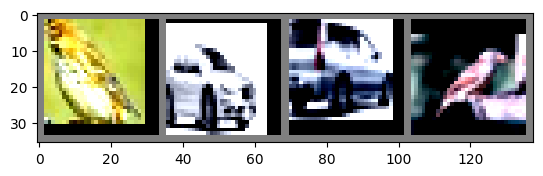

bird  automobile automobile bird 


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Convert from CxHxW to HxWxC for displaying
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:4]))

# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Building and Training the Multi-Layer Perceptron (MLP)

Defining the MLP Model

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes = 10):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

Instantiate the Model, Define Loss Function and Optimizer

In [ ]:
input_size_mlp = 3 * 32 * 32
hidden_size1_mlp = 512
hidden_size2_mlp = 256
num_classes = 10
learning_rate_mlp = 0.001
num_epochs_mlp = 20

# Create the MLP model instance
mlp_model = MLP(input_size_mlp, hidden_size1_mlp, hidden_size2_mlp, num_classes).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=learning_rate_mlp)

Training and Validation Loop for MLP

In [ ]:
# Lists to store metrics for MLP
mlp_train_losses = []
mlp_train_accuracies = []
mlp_val_losses = []
mlp_val_accuracies = []

print("Starting MLP Training...")
for epoch in range(num_epochs_mlp):
    # --- Training ---
    mlp_model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = mlp_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer_mlp.zero_grad()
        loss.backward()
        optimizer_mlp.step()

        # Accumulate loss
        running_train_loss += loss.item() * images.size(0)

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_dataset)
    epoch_train_accuracy = 100 * correct_train / total_train
    mlp_train_losses.append(epoch_train_loss)
    mlp_train_accuracies.append(epoch_train_accuracy)

    # --- Validation ---
    mlp_model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = mlp_model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_dataset)
    epoch_val_accuracy = 100 * correct_val / total_val
    mlp_val_losses.append(epoch_val_loss)
    mlp_val_accuracies.append(epoch_val_accuracy)

    print(f"MLP Epoch [{epoch+1}/{num_epochs_mlp}], "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%")

print("MLP Training Finished.")

Starting MLP Training...
MLP Epoch [1/20], Train Loss: 1.8415, Train Acc: 33.23%, Val Loss: 1.7602, Val Acc: 35.94%
MLP Epoch [2/20], Train Loss: 1.6855, Train Acc: 39.22%, Val Loss: 1.6468, Val Acc: 40.59%
MLP Epoch [3/20], Train Loss: 1.6181, Train Acc: 41.73%, Val Loss: 1.5829, Val Acc: 43.09%
MLP Epoch [4/20], Train Loss: 1.5837, Train Acc: 42.89%, Val Loss: 1.5656, Val Acc: 44.22%
MLP Epoch [5/20], Train Loss: 1.5493, Train Acc: 44.26%, Val Loss: 1.5622, Val Acc: 44.02%
MLP Epoch [6/20], Train Loss: 1.5266, Train Acc: 45.08%, Val Loss: 1.5572, Val Acc: 44.76%
MLP Epoch [7/20], Train Loss: 1.5089, Train Acc: 45.67%, Val Loss: 1.5202, Val Acc: 45.44%
MLP Epoch [8/20], Train Loss: 1.4944, Train Acc: 46.25%, Val Loss: 1.5023, Val Acc: 46.28%
MLP Epoch [9/20], Train Loss: 1.4736, Train Acc: 47.03%, Val Loss: 1.5017, Val Acc: 45.85%
MLP Epoch [10/20], Train Loss: 1.4645, Train Acc: 47.42%, Val Loss: 1.5025, Val Acc: 46.29%
MLP Epoch [11/20], Train Loss: 1.4540, Train Acc: 47.94%, Val Lo

# Building and Training the Convolutional Neural Network (CNN)

Defining the CNN Model

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flattened_size = 64 * 4 * 4

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Layer 3
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Flatten and pass to fully connected layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        return x

Instantiate the CNN Model, Define Loss Function and Optimizer

In [ ]:
# Hyperparameters for the CNN model and training
learning_rate_cnn = 0.001
num_epochs_cnn = 25

# Create the CNN model instance
cnn_model = CNN(num_classes=num_classes).to(device)

# Optimizer
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=learning_rate_cnn)

Training and Validation Loop for CNN

In [ ]:
# Lists to store metrics for CNN
cnn_train_losses = []
cnn_train_accuracies = []
cnn_val_losses = []
cnn_val_accuracies = []

print("\nStarting CNN Training...")
for epoch in range(num_epochs_cnn):
    # --- Training ---
    cnn_model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer_cnn.zero_grad()
        loss.backward()
        optimizer_cnn.step()

        running_train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_dataset)
    epoch_train_accuracy = 100 * correct_train / total_train
    cnn_train_losses.append(epoch_train_loss)
    cnn_train_accuracies.append(epoch_train_accuracy)

    # --- Validation ---
    cnn_model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_dataset)
    epoch_val_accuracy = 100 * correct_val / total_val
    cnn_val_losses.append(epoch_val_loss)
    cnn_val_accuracies.append(epoch_val_accuracy)

    print(f"CNN Epoch [{epoch+1}/{num_epochs_cnn}], "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%")

print("CNN Training Finished.")


Starting CNN Training...
CNN Epoch [1/25], Train Loss: 1.6411, Train Acc: 39.81%, Val Loss: 1.4309, Val Acc: 47.50%
CNN Epoch [2/25], Train Loss: 1.3020, Train Acc: 53.16%, Val Loss: 1.2171, Val Acc: 57.08%
CNN Epoch [3/25], Train Loss: 1.1559, Train Acc: 58.72%, Val Loss: 1.1135, Val Acc: 59.82%
CNN Epoch [4/25], Train Loss: 1.0583, Train Acc: 62.62%, Val Loss: 1.0195, Val Acc: 63.49%
CNN Epoch [5/25], Train Loss: 0.9887, Train Acc: 65.16%, Val Loss: 0.9653, Val Acc: 65.80%
CNN Epoch [6/25], Train Loss: 0.9312, Train Acc: 67.09%, Val Loss: 0.9177, Val Acc: 68.00%
CNN Epoch [7/25], Train Loss: 0.8916, Train Acc: 68.59%, Val Loss: 0.8887, Val Acc: 68.91%
CNN Epoch [8/25], Train Loss: 0.8576, Train Acc: 69.63%, Val Loss: 0.8593, Val Acc: 69.42%
CNN Epoch [9/25], Train Loss: 0.8250, Train Acc: 71.01%, Val Loss: 0.8646, Val Acc: 70.03%
CNN Epoch [10/25], Train Loss: 0.8031, Train Acc: 71.79%, Val Loss: 0.8080, Val Acc: 71.99%
CNN Epoch [11/25], Train Loss: 0.7851, Train Acc: 72.45%, Val L

# Evaluating the Models

Testing the Models on the Test Set

In [ ]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_predicted = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = 100 * correct_test / total_test

    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    return avg_test_loss, test_accuracy, all_labels, all_predicted

# Test the MLP model
print("\nTesting MLP Model :")
mlp_test_loss, mlp_test_accuracy, mlp_true_labels, mlp_predicted_labels = test_model(mlp_model, test_loader, criterion, device)

# Test the CNN model
print("\nTesting CNN Model :")
cnn_test_loss, cnn_test_accuracy, cnn_true_labels, cnn_predicted_labels = test_model(cnn_model, test_loader, criterion, device)


Testing MLP Model :
Test Loss: 1.6311, Test Accuracy: 42.77%

Testing CNN Model :
Test Loss: 0.6882, Test Accuracy: 77.01%


Plotting Learning Curves

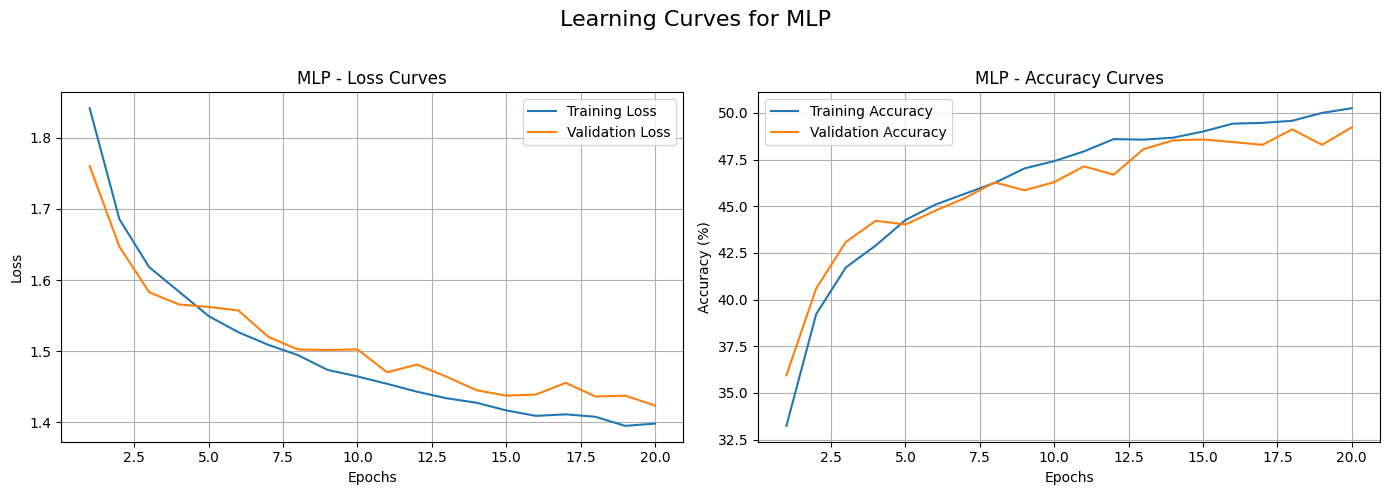

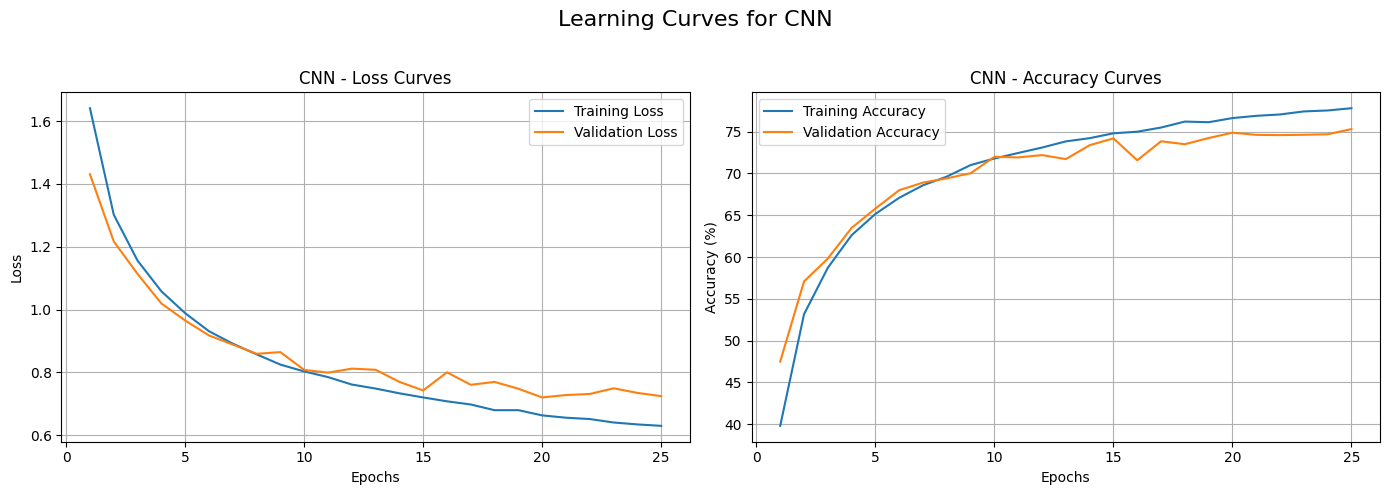

In [ ]:
def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name, num_epochs):
    epochs_range = range(1, num_epochs + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss Curves')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model_name} - Accuracy Curves')
    plt.legend()
    plt.grid(True)

    plt.suptitle(f'Learning Curves for {model_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot learning curves for MLP
plot_learning_curves(mlp_train_losses, mlp_val_losses,
                     mlp_train_accuracies, mlp_val_accuracies,
                     "MLP", num_epochs_mlp)

# Plot learning curves for CNN
plot_learning_curves(cnn_train_losses, cnn_val_losses,
                     cnn_train_accuracies, cnn_val_accuracies,
                     "CNN", num_epochs_cnn)

Plotting Confusion Matrices

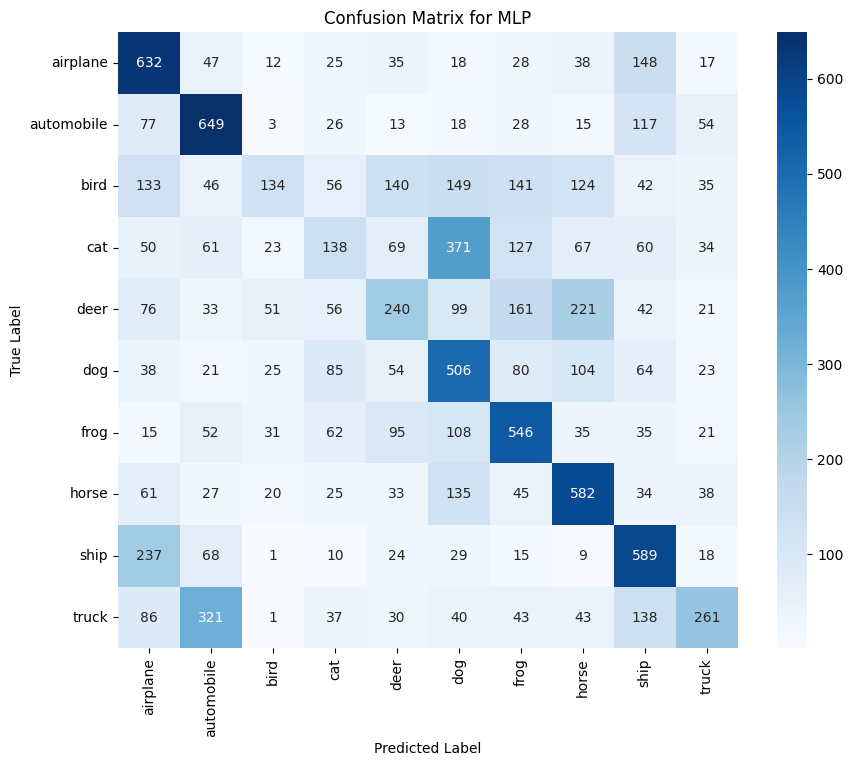

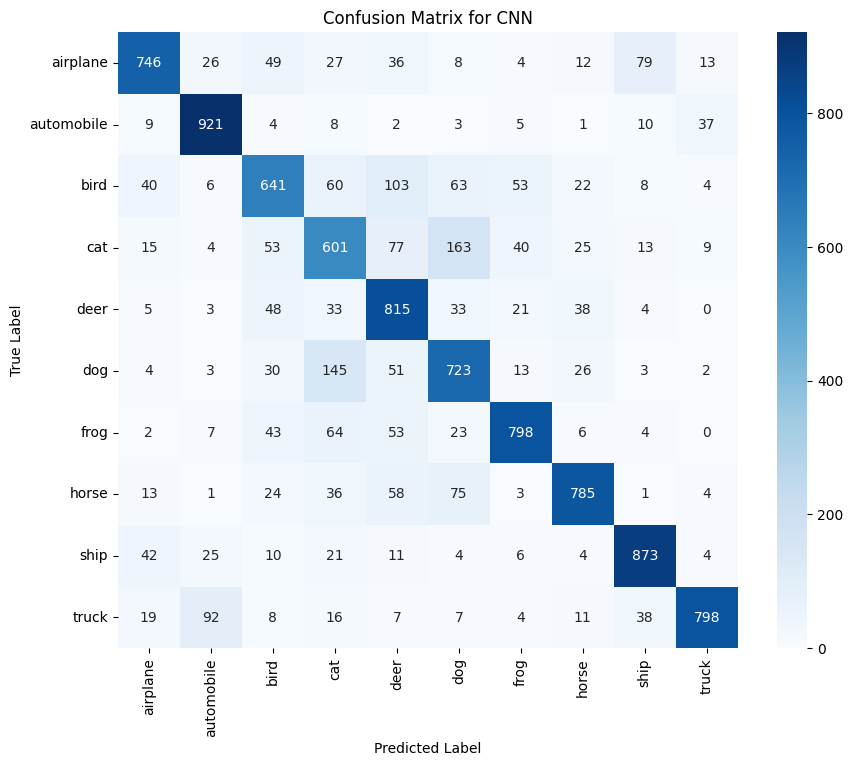

In [ ]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names, model_name):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Plot confusion matrix for MLP
plot_confusion_matrix(mlp_true_labels, mlp_predicted_labels, classes, "MLP")

# Plot confusion matrix for CNN
plot_confusion_matrix(cnn_true_labels, cnn_predicted_labels, classes, "CNN")